# Load

## Libs

In [5]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


## Data

In [24]:
enrich_res <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_enrich_res.rds')
meta_data <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/metadata.rds') %>% data.frame()
genes_dynamic_pos <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_genes_dynamic_pos.rds')
lres_dynamic <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_lres_dynamics.rds')
lres_peaks <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_lres_peaks.rds')
logcpm <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/logcpm.rds')
hres <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_hres.rds')

In [7]:
m <- meta_data %>% 
    dplyr::mutate(
        TimePoint = case_when(
            Case == 'SS' ~ 'D0', 
            TRUE ~ TimePoint
        ),
        TimeInt = case_when(
            Case == 'SS' ~ 0L, 
            TRUE ~ TimeInt
        )        
    ) %>% 
#     subset(TimePoint != 'D0') %>% 
    subset(LibraryID != 'Lib1_B') %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14)))) %>% 
    dplyr::arrange(TimePoint)


In [8]:
m_kinchen <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_obj_mouse_stromal.rds')$meta_data

# Mural not expanded in single-cell DSS

In [9]:
plt_df <- with(m_kinchen, table(LibraryID, lineage)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(m_kinchen, LibraryID, Status))) %>% 
    dplyr::mutate(Status = factor(Status, c('HC', 'DSS'))) %>% 
    identity()
stats_res <- data.table(plt_df)[, broom::tidy(t.test(N ~ Status, .SD, alternative = 'less')), by = lineage][order(p.value)][, padj := p.adjust(p.value, 'BH')][, .(lineage, p.value)]
plt_df <- plt_df %>% left_join(stats_res)

Joining, by = "LibraryID"

Joining, by = "lineage"



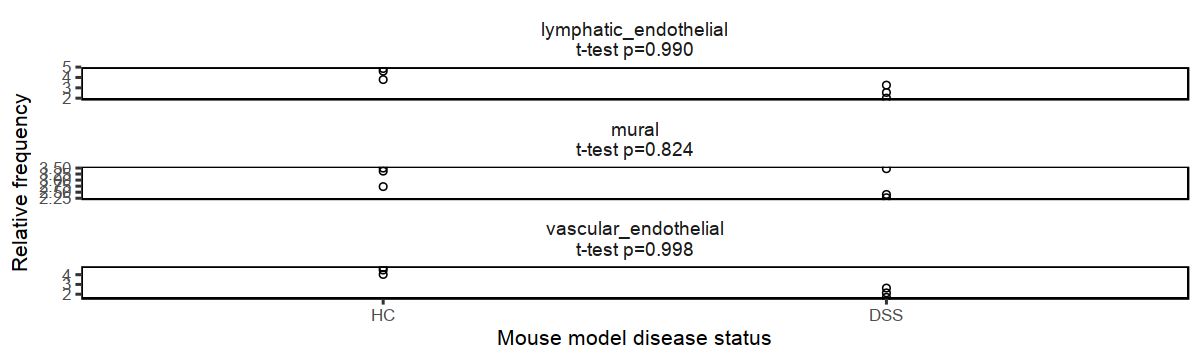

In [10]:
fig.size(3, 10)
p0 <- plt_df %>% 
    dplyr::mutate(LABEL = sprintf('%s\nt-test p=%0.3f', lineage, p.value)) %>% 
    subset(grepl('^lymphatic|^vascular|^mural', LABEL)) %>% 
    ggplot(aes(Status, 100 * N)) + 
        geom_point(shape = 21) + 
        facet_wrap(~LABEL, scales = 'free_y', ncol = 1) + 
#         facet_wrap(~LABEL, scales = 'free_y', nrow = 1) + 
        labs(x = 'Mouse model disease status', y = 'Relative frequency') +  
        NULL
p0

# Time-distribution of dynamic genes

In [11]:
# set.seed(42L)
# X <- scaleData(logcpm[genes_dynamic_pos, m$LibraryID], 1, 5)

# .names <- rep('', ncol(X))
# .names[c(1, 6, 13, 18, 24, 30, 36) + 3] <- gsub('D', 'Day ', levels(m$TimePoint))
# # .names[c(1, 6, 13, 18, 24, 30, 36)] <- gsub('D', 'Day ', levels(m$TimePoint))
# colnames(X) <- .names

# ht_opt(RESET = TRUE)
# ht_opt("heatmap_column_names_gp" = gpar(fontsize = 6))
# ht_opt("heatmap_row_names_gp" = gpar(fontsize = 6))

# fig.size(10, 6)
# set.seed(41L)
# p9 <- Heatmap(
#     X[rownames(arrange(hres, Class)), ], 
#     cluster_rows = FALSE, 
#     cluster_columns = FALSE,
#     name = 'scaled\nlogCPM',
# #     show_column_names = FALSE,
#     column_names_rot = 0,
#     bottom_annotation = columnAnnotation(
#         df = dplyr::select(m, TimePoint),
#         show_annotation_name = FALSE, show_legend = FALSE
#     ),
#     right_annotation = rowAnnotation(
#         df = data.frame(group=arrange(hres, Class)),
#         col = list(Class = c(Inflammation=tableau_color_pal()(2)[1], Resolution=tableau_color_pal()(2)[2])),
#         show_annotation_name = FALSE, show_legend = FALSE
#     )
# )
# p9 <- grid.grabExpr(draw(p9))
# wrap_elements(full = p9)


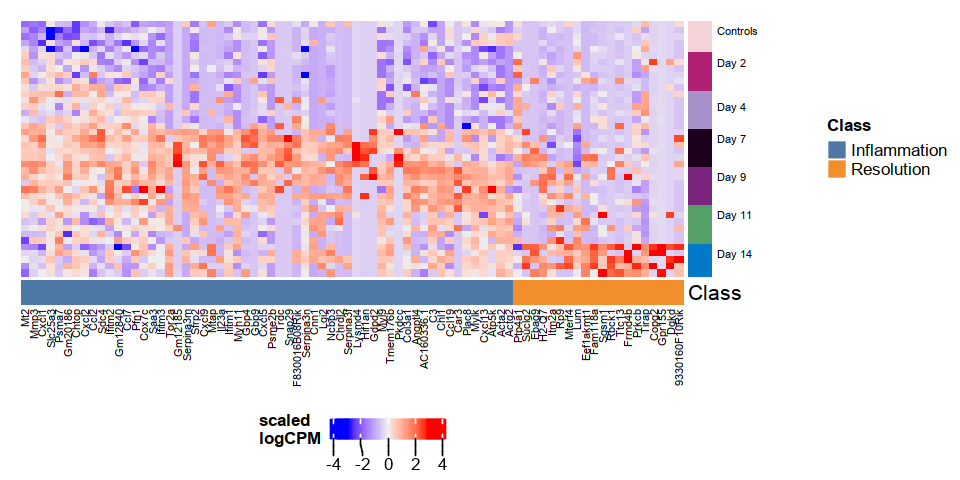

In [12]:
set.seed(42L)
X <- scaleData(logcpm[genes_dynamic_pos, m$LibraryID], 1, 5)

.levels <- levels(m$TimePoint)
.levels[1] <- 'Controls'
.names <- rep('', ncol(X))
.names[1 + c(1, 6, 13, 18, 24, 30, 36)] <- gsub('D', 'Day ', .levels)
# .names[1 + c(1, 6, 13, 18, 24, 30, 36)] <- gsub('D', 'Day ', levels(m$TimePoint))
colnames(X) <- .names

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 6))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 6))

fig.size(4, 8)
set.seed(41L)
p1 <- Heatmap(
    t(X[rownames(arrange(hres, Class)), ]), 
    cluster_rows = FALSE, 
    cluster_columns = FALSE,
    name = 'scaled\nlogCPM',
#     show_column_names = FALSE,
#     column_names_rot = 0,
    right_annotation = rowAnnotation(
        df = dplyr::select(m, TimePoint),
        show_annotation_name = FALSE, show_legend = FALSE
    ),
    bottom_annotation = columnAnnotation(
        df = data.frame(group=arrange(hres, Class)),
        col = list(Class = c(Inflammation=tableau_color_pal()(2)[1], Resolution=tableau_color_pal()(2)[2]))
#         annotation_legend_param = list(direction = 'horizontal')
#         show_annotation_name = FALSE, show_legend = FALSE
    ),
    heatmap_legend_param = list(
        legend_direction = "horizontal",
        title_position = 'lefttop',
        legend_height = unit(2, "cm")
    ),
    
)
# p1 <- grid.grabExpr(draw(p1))
p1 <- grid.grabExpr(draw(
    p1, 
    heatmap_legend_side = "bottom",
    annotation_legend_side = "right",
    padding = unit(c(5, 2, 2, 13), "mm")  #bottom, left, top, right paddings  
))
wrap_elements(p1)


# FACS %CD45+ 

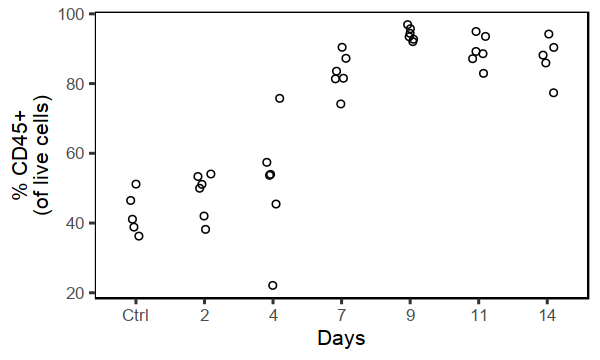

In [13]:
fig.size(3, 5)
set.seed(42L)
.x <- fread('/data/srlab2/ik936/Roche/data/DSS/facs_immune.txt')[!is.na(V4), V2:V8] %>% 
#     dplyr::mutate(V2 = paste0('D', V2)) %>% 
    dplyr::rename(TimePoint = V2) %>% 
    tidyr::gather(rep, val, -TimePoint) %>% 
    subset(!is.na(val)) %>% 
    dplyr::mutate(TimePoint = case_when(
        TimePoint == '0' ~ 'Ctrl',
        TRUE ~ TimePoint
    )) %>% 
#     dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14))))
    dplyr::mutate(TimePoint = factor(TimePoint, c('Ctrl', '2', '4', '7', '9', '11', '14'))) %>% 
    identity() 

p2 <- .x %>% 
    ggplot(aes(TimePoint, val)) +
        geom_point(shape = 21, position = position_jitter(width = .1)) + 
        labs(x = 'Days', y = '% CD45+\n(of live cells)') + 
#         scale_y_log10() + 
        NULL
p2

# Plot enrichment stats

In [42]:
# enrich_res

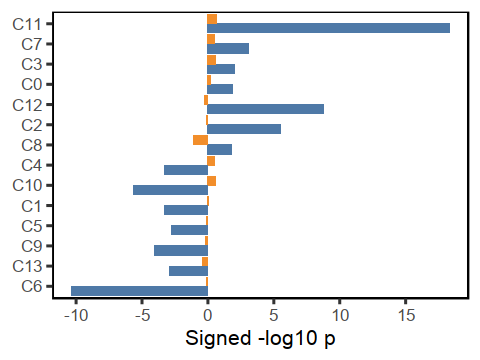

In [57]:
fig.size(3, 4)
p3 <- enrich_res %>% 
    ggplot(aes(reorder(Cluster, NES), sign(NES) * -log10(pval), fill = pathway)) + 
#     ggplot(aes(reorder(Cluster, zscore), zscore, fill = Class)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        scale_fill_tableau() + 
        coord_flip() + 
#         geom_hline(yintercept = -log10(.01), linetype = 2) + 
        labs(y = 'Signed -log10 p') + 
        theme(axis.title.y = element_blank()) + 
        guides(fill = 'none') + 
        scale_y_continuous(breaks = seq(-25, 25, by = 5)) + 
        NULL
p3

In [56]:
# fig.size(3, 4)
# p3 <- enrich_res %>% 
#     ggplot(aes(reorder(Cluster, zscore), sign(zscore) * -log10(p), fill = Class)) + 
# #     ggplot(aes(reorder(Cluster, zscore), zscore, fill = Class)) + 
#         geom_bar(stat = 'identity', position = position_dodge()) + 
#         scale_fill_tableau() + 
#         coord_flip() + 
# #         geom_hline(yintercept = -log10(.01), linetype = 2) + 
#         labs(y = 'Signed -log10 p') + 
#         theme(axis.title.y = element_blank()) + 
#         guides(fill = 'none') + 
#         NULL
# p3

# Time course of C11 leading edge genes 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



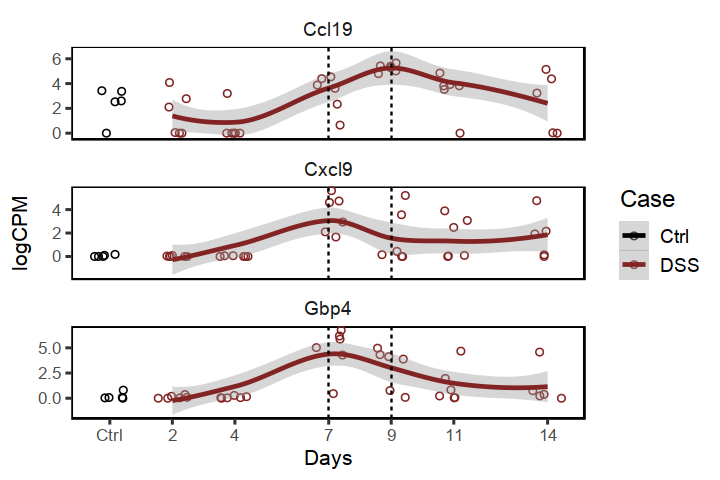

In [15]:
# .genes <- c('Ccl2', 'Ccl19', 'Ifitm1')
.genes <- c('Cxcl9', 'Ccl19', 'Gbp4')

fig.size(4, 6)
p4 <- m %>% 
    cbind(as.matrix(t(logcpm[.genes, m$LibraryID]))) %>% 
    tidyr::gather(key, val, one_of(.genes)) %>%
    dplyr::mutate(Case = c(SS='Ctrl', DSS='DSS')[Case]) %>% 
    ggplot(aes(TimeInt, val, color = Case)) + 
        geom_point(shape = 21, position = position_jitter(width = .5, height = 0)) + 
        geom_smooth() + 
        facet_wrap(~key, scales = 'free_y', ncol = 1) + 
        scale_x_continuous(breaks = c(0, 2, 4, 7, 9, 11, 14), labels = c('Ctrl', '2', '4', '7', '9', '11', '14')) + 
        labs(y = 'logCPM', x = 'Days') + 
        geom_vline(xintercept = c(7, 9), linetype = 2) + 
        scale_color_manual(values = c('black', muted('red'))) +  
        NULL
p4

# Noise in C4 genes (not included) 

In [16]:
# # .genes <- c('Ccl2', 'Ccl19', 'Ifitm1')
# # .genes <- c('Cxcl9', 'Ccl19', 'Gbp4')
# .genes <- c('Postn', 'Thy1', 'Sparc')


# fig.size(4, 6)
# p5 <- m %>% 
#     cbind(as.matrix(t(logcpm[.genes, m$LibraryID]))) %>% 
#     tidyr::gather(key, val, one_of(.genes)) %>%
#     dplyr::mutate(Case = c(SS='Ctrl', DSS='DSS')[Case]) %>% 
#     ggplot(aes(TimeInt, val, color = Case)) + 
#         geom_point(shape = 21, position = position_jitter(width = .5, height = 0)) + 
#         geom_smooth() + 
#         geom_boxplot(data = . %>% subset(Case == 'Ctrl'), fill = NA, outlier.shape = NA) + 
#         facet_wrap(~key, scales = 'free_y', ncol = 1) + 
#         scale_x_continuous(breaks = c(0, 2, 4, 7, 9, 11, 14), labels = c('Ctrl', '2', '4', '7', '9', '11', '14')) + 
#         labs(y = 'logCPM', x = 'Days') + 
# #         geom_vline(xintercept = c(7, 9), linetype = 2) + 
#         scale_color_manual(values = c('black', muted('red'))) +  
#         NULL
# p5

# Thy1 qPCR (not included) 

In [17]:
# qpcr_df <- fread('/data/srlab2/ik936/Roche/data/DSS/qpcr_thy1.txt')[!is.na(sample_number)][, sample_number := NULL][] %>% 
#     tidyr::spread(Target, Cq) %>%
#     dplyr::mutate(val = 2^-(THY1 - Gapdh))


# p6 <- m %>% 
#     dplyr::mutate(Sample = gsub('Lib(\\d+)_.', '\\1F', LibraryID)) %>% 
#     dplyr::select(Sample, Case, TimePoint, TimeInt) %>% 
#     left_join(qpcr_df) %>% 
#     dplyr::mutate(Case = c(SS='Ctrl', DSS='DSS')[Case]) %>% 
#     ggplot(aes(TimeInt, val, group = TimeInt)) + 
#         geom_boxplot(outlier.shape = NA, width = .75) + 
#         scale_x_continuous(breaks = c(0, 2, 4, 7, 9, 11, 14), labels = c('Ctrl', '2', '4', '7', '9', '11', '14')) + 
#         geom_jitter(width = .2, height = 0, shape = 21) + 
#         labs(x = '', y = '2^-Delta Ct\n(Thy1-Gapdh)') + 
#         NULL
    
# p6

# Panels

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



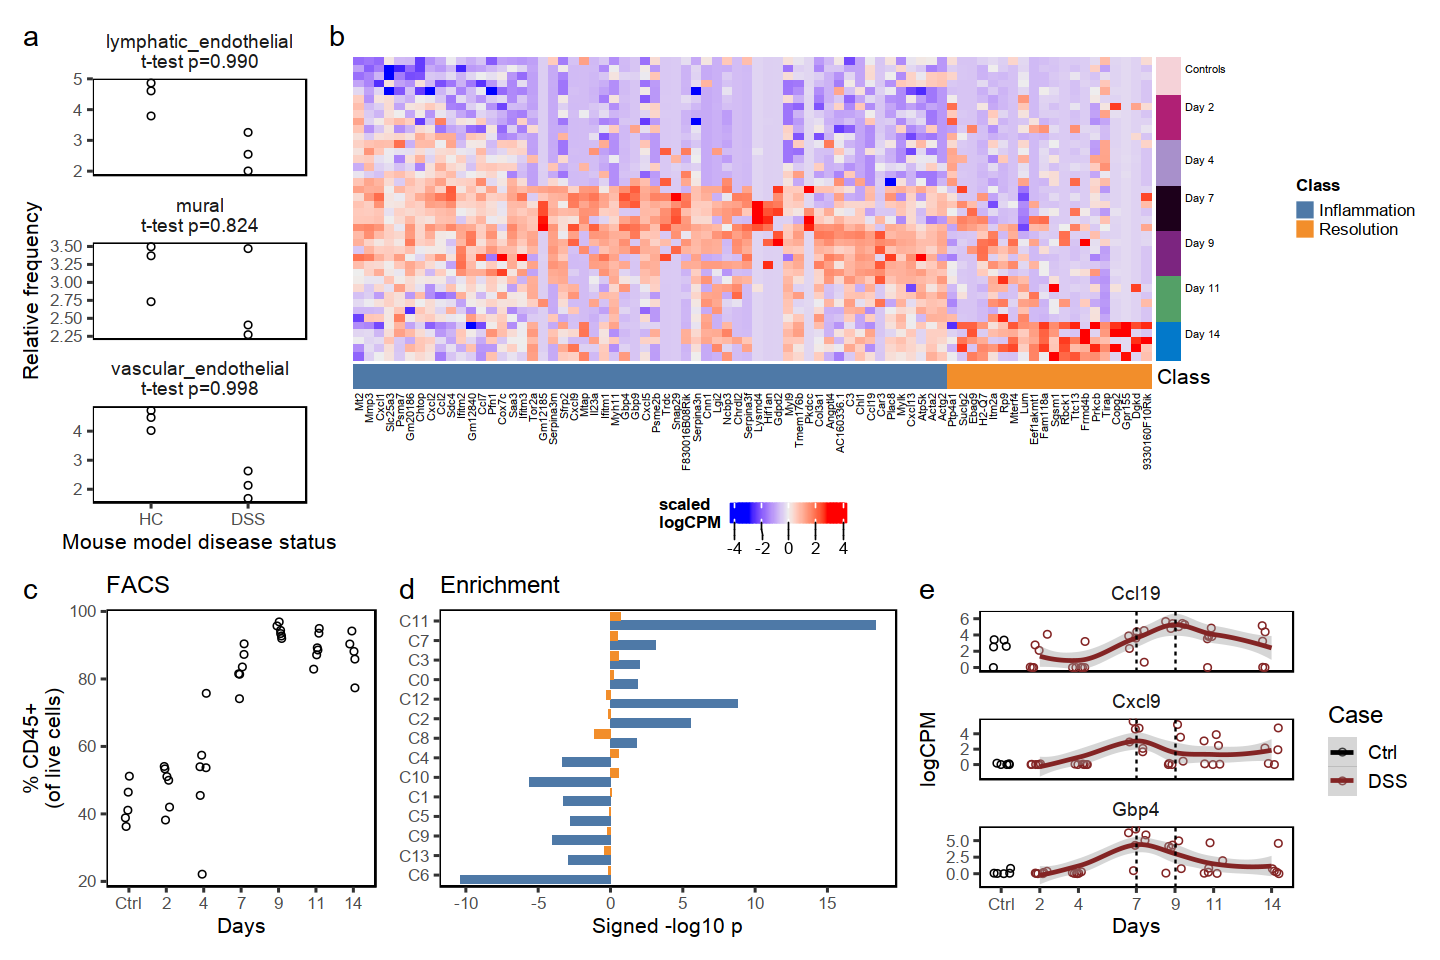

In [72]:
fig.size(8, 12)
plt <- (
    (
       (wrap_elements(full = p0) | wrap_elements(p1)) + plot_layout(widths = c(1, 4))
    ) / 
    (
        (
            wrap_elements(full = p2 + labs(subtitle = 'FACS')) | 
            wrap_elements(full = p3 + labs(subtitle = 'Enrichment')) | 
            wrap_elements(full = p4 + theme(legend.position = 'right'))
        ) + plot_layout(widths = c(.7, 1, 1))
    )

) + 
    plot_layout(heights = c(1.5, 1)) + 
    plot_annotation(tag_levels = 'a')
plt

In [73]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/SuppFigure11.pdf', 
    plot = plt, 
    units = 'in', device = 'pdf', 
    height = 8, width = 12,
    useDingbats = FALSE
)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

